### Импорт

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR


### Загрузка


In [70]:
dataset = pd.read_csv("./prepared_datasets/regression_ic50.csv")

X = dataset.drop(columns=["log_IC50, mM"])
y = dataset["log_IC50, mM"]


### Трейн/тест выборки

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train.shape, X_test.shape

((683, 71), (171, 71))

### Набор моделей + гиперпараметры

In [72]:
# словарь моделей и их гиперпараметров
param_grids = {
    "LinearRegression": {
        "model": [LinearRegression()]
    },
    "DecisionTree": {
        "model": [DecisionTreeRegressor(random_state=42)],
        "model__max_depth": randint(3, 15),
        "model__min_samples_split": randint(2, 20)
    },
    "RandomForest": {
        "model": [RandomForestRegressor(random_state=42, n_jobs=-1)],
        "model__n_estimators": randint(100, 500),
        "model__max_depth": randint(3, 15),
        "model__min_samples_split": randint(2, 20)
    },
    "CatBoost": {
        "model": [CatBoostRegressor(verbose=0, random_state=42)],
        "model__depth": randint(4, 10),
        "model__learning_rate": uniform(0.01, 0.2),
        "model__iterations": randint(200, 600)
    },
    "MLP": {
        "model": [MLPRegressor(max_iter=500, random_state=42)],
        "model__hidden_layer_sizes": [(64, 32), (128, 64), (256, 128)],
        "model__alpha": uniform(0.0001, 0.01),
        "model__learning_rate_init": uniform(0.001, 0.05)
    },
    "SVR": {
        "model": [SVR(max_iter=2000)],
        "model__C": uniform(0.1, 10),
        "model__epsilon": uniform(0.01, 0.5),
        "model__kernel": ["linear", "rbf"]
    }
}


### Поиск лучших гиперпараметров и сводная таблица

In [73]:
# вспомогательный метод
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [74]:
results = []

for name, param_grid in param_grids.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()), # деревьям всё равно, а для SVR полезно
        ("model", param_grid["model"][0])
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=12,
        cv=3,
        scoring="r2", # подбираем по R2
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": rmse(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
results_df

C:\Users\mihga\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=12. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,Model,Best Params,MAE,RMSE,R2
3,CatBoost,{'model': <catboost.core.CatBoostRegressor obj...,0.440335,0.569124,0.539629
2,RandomForest,"{'model': RandomForestRegressor(n_jobs=-1, ran...",0.446543,0.580440,0.521141
5,SVR,"{'model': SVR(max_iter=2000), 'model__C': 7.89...",0.507152,0.648014,0.403155
0,LinearRegression,{'model': LinearRegression()},0.503099,0.652469,0.394919
1,DecisionTree,{'model': DecisionTreeRegressor(random_state=4...,0.543274,0.683518,0.335961
4,MLP,"{'model': MLPRegressor(max_iter=500, random_st...",0.575479,0.770097,0.157083


### Графики сравнения моделей по метрикам

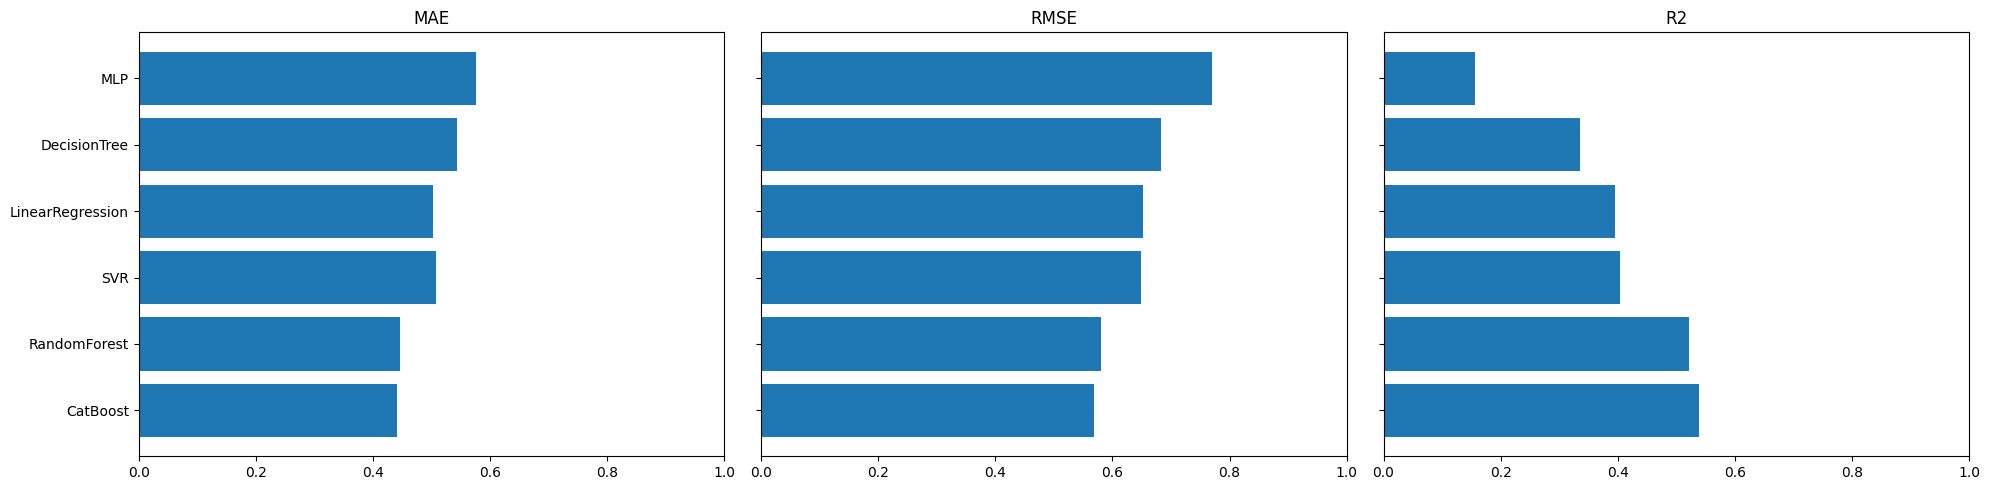

In [75]:
# Barplot всех моделей
metrics = ["MAE", "RMSE", "R2"]

fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)
for i, metric in enumerate(metrics):
    axes[i].barh(results_df["Model"], results_df[metric])
    axes[i].set_title(metric)
    axes[i].set_xlim(0, 1)
plt.tight_layout()
plt.show()


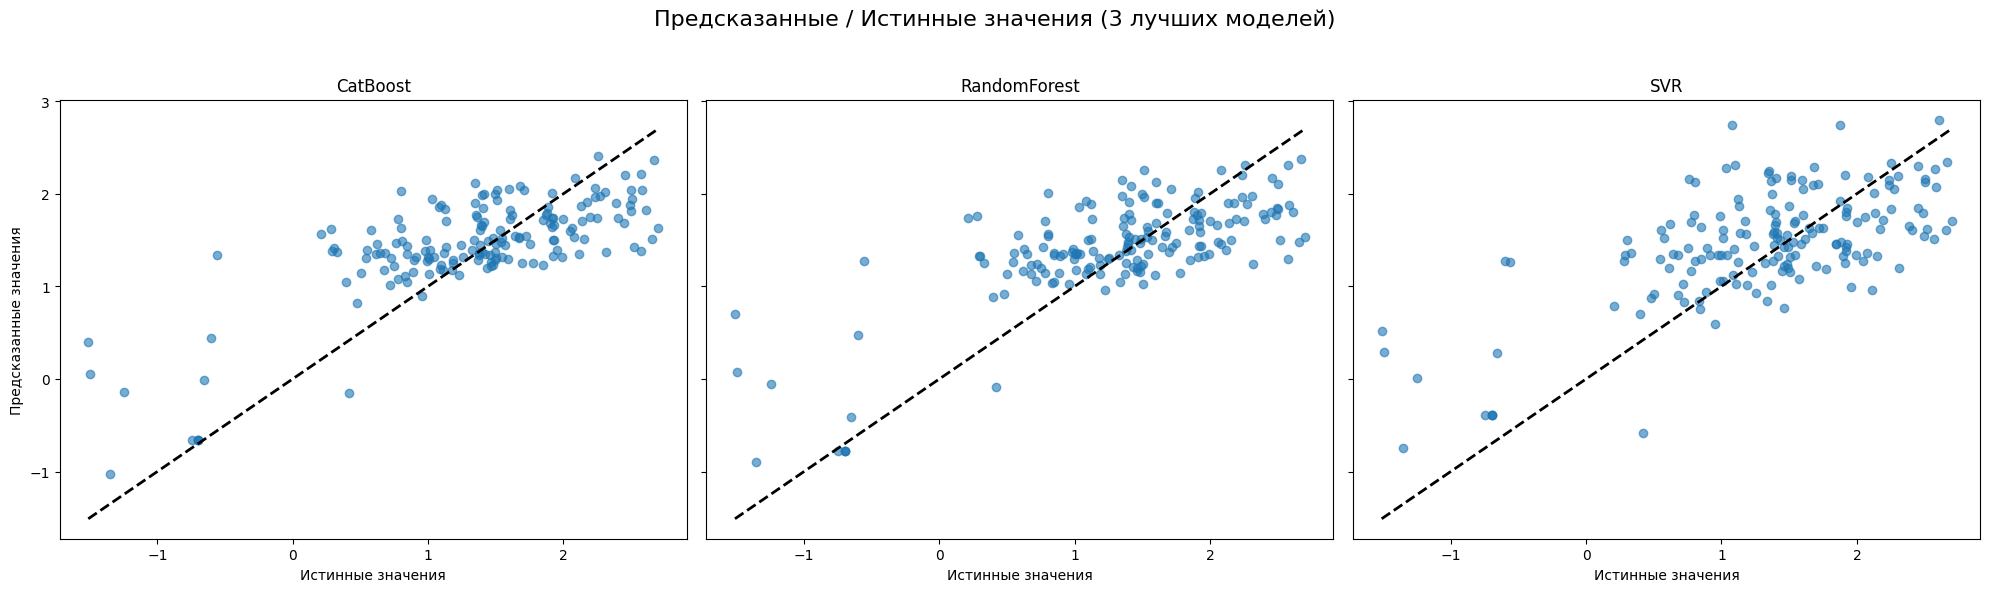

In [76]:
# Берём 3 лучшие модели по R2
top_models = results_df.sort_values("R2", ascending=False).head(3)["Model"].values

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True, sharex=True)

for i, name in enumerate(top_models):
    # Создаём Pipeline с лучшими параметрами
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", param_grids[name]["model"][0])
    ])
    best_params = results_df.loc[results_df["Model"] == name, "Best Params"].values[0]
    pipe.set_params(**best_params)

    # Обучаем и предсказываем
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Строим scatter plot
    axes[i].scatter(y_test, y_pred, alpha=0.6)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[i].set_title(name)
    axes[i].set_xlabel("Истинные значения")
    if i == 0:
        axes[i].set_ylabel("Предсказанные значения")

plt.suptitle("Предсказанные / Истинные значения (3 лучших моделей)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Вывод по данной задаче


Наиболее удачными являются модели CatBoost и RandomForest.

Простые модели, такие как линейная регрессия, дерево решений и т.д. не справляются с нелинейной структурой данных.

<br>

Для улучшения качества можно:
   - расширить гиперпараметрический поиск для CatBoost; 
   - протестировать ансамблирование CatBoost и RandomForest;